<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [4]:
# imports
import numpy as np
import gensim
import os
import re
import spacy

import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis.gensim

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from ast import literal_eval
from tqdm import tqdm

from gensim.models.ldamulticore import LdaMulticore

import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [7]:
import spacy.cli
spacy.cli.download("en_core_web_lg")
import en_core_web_lg

nlp = en_core_web_lg.load()

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [8]:
# read in data and first look
df = pd.read_csv('./data/amazon_reviews.csv')

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
df.head()

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [28]:
# establish additional stop words
STOP_WORDS = nlp.Defaults.stop_words.union(['batteries','I', 'amazon', 'i', 'Amazon', 'it', "it's", 'it.', 'the', 'this',])

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
# create a new column for tokens, removing stop words and punctuation
tokens = []
for doc in nlp.pipe(df['reviews.text'], batch_size=500):
    doc_tokens = []
    
    for token in doc:
        if (token.is_punct == False) & (token.text.lower() not in STOP_WORDS):
            doc_tokens.append(token.text.lower())
        
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
# establish lemmas as keywords 
def get_lemmas(text):"""
A function to get the lemmas of a document, applying spacy basic stop word, punctuation,
and pronoun removal.
ARGS:
    text: Document or text to be lemmatized
RETURNS:
    lemmas: Lemmas of the text
"""
    lemmas = []
    
    doc = nlp(text)
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

df['keywords'] = df['reviews.text'].apply(get_lemmas)

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


IndentationError: unexpected indent (<ipython-input-67-c166f2de8be8>, line 5)

In [33]:
df.head()

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,tokens,keywords
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, 3, item, bad, quality, missing, backup...","[order, 3, item, bad, quality, miss, backup, s..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, products, like]","[bulk, expensive, way, product, like]"
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...","[duracell, price, happy]","[Duracell, price, happy]"
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...","[work, brand, better, price]","[work, brand, battery, well, price]"
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...","[long, lasting, price, great]","[battery, long, last, price, great]"


In [34]:
df['keywords'][0]

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['order',
 '3',
 'item',
 'bad',
 'quality',
 'miss',
 'backup',
 'spring',
 'pc',
 'aluminum',
 'battery',
 'work']

In [35]:
# running the full stop word removal over the keywords, creating
# cleaned_keywords column
def remove_stops(_list_):
    
    keywords = []
    
    for keyword in _list_:
        
        phrase = []
        words = keyword.split()
        
        for word in words:
            if word in STOP_WORDS:
                pass
            else:
                phrase.append(word)
        
        phrase = ' '.join(phrase)
        
        if len(phrase) >0:
            keywords.append(phrase)
    
    return keywords

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
from tqdm import tqdm

tqdm.pandas()

df['clean_keywords'] = df['keywords'].progress_apply(remove_stops)

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 28332/28332 [00:00<00:00, 92384.53it/s] 


In [38]:
# pull out keywords from the cleaned set that sit at the high and low
# extremes regarding word count and establishing a corpus
id2word = corpora.Dictionary(df['clean_keywords'])
id2word.filter_extremes(no_below=5, no_above=0.85)

corpus = [id2word.doc2bow(text) for text in df['clean_keywords']]

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# apply a Latent Dirchilet Allocation model to the corpus to get topics
lda = LdaMulticore(corpus=corpus,
                  id2word=id2word,
                  num_topics=50,
                  passes=50,
                  workers=12)
lda.print_topics()

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(42,
  '0.053*"Friday" + 0.049*"tv" + 0.045*"sale" + 0.038*"Black" + 0.037*"tablet" + 0.028*"good" + 0.027*"internet" + 0.026*"watch" + 0.024*"great" + 0.020*"stream"'),
 (14,
  '0.091*"expect" + 0.087*"look" + 0.047*"tablet" + 0.042*"good" + 0.038*"need" + 0.035*"price" + 0.034*"satisfied" + 0.027*"performance" + 0.027*"exactly" + 0.026*"HD8"'),
 (35,
  '0.239*"battery" + 0.119*"good" + 0.097*"long" + 0.064*"brand" + 0.060*"great" + 0.055*"price" + 0.054*"life" + 0.040*"deal" + 0.030*"buy" + 0.026*"far"'),
 (21,
  '0.045*"tablet" + 0.025*"like" + 0.021*"device" + 0.016*"multiple" + 0.013*"cover" + 0.011*"girl" + 0.011*"difficult" + 0.011*"prefer" + 0.011*"item" + 0.011*"miss"'),
 (24,
  '0.044*"device" + 0.039*"app" + 0.023*"screen" + 0.021*"tablet" + 0.018*"magazine" + 0.015*"use" + 0.015*"view" + 0.010*"close" + 0.010*"home" + 0.010*"button"'),
 (38,
  '0.249*"great" + 0.223*"price" + 0.109*"product" + 0.093*"good" + 0.051*"value" + 0.044*"tablet" + 0.037*"quality" + 0.025*"beat" +

In [41]:
words = [re.findall(r'"[^"]*"', t[1]) for t in lda.print_topics(50)]

topic_labels = [', '.join(t[0:5]) for t in words]

for id, t in enumerate(topic_labels):
    print(f"----- Topic {id} -----")
    print(t, end="\n\n")

----- Topic 0 -----
"kid", "tablet", "great", "friendly", "love"

----- Topic 1 -----
"convenient", "great", "like", "want", "space"

----- Topic 2 -----
"small", "fit", "size", "screen", "need"

----- Topic 3 -----
"storage", "super", "speed", "great", "ease"

----- Topic 4 -----
"time", "awesome", "kid", "set", "limit"

----- Topic 5 -----
"battery", "brand", "buy", "long", "use"

----- Topic 6 -----
"reader", "perfect", "e", "size", "right"

----- Topic 7 -----
"app", "case", "kid", "come", "learn"

----- Topic 8 -----
"excellent", "tablet", "ipad", "fun", "especially"

----- Topic 9 -----
"game", "play", "watch", "movie", "love"

----- Topic 10 -----
"trip", "long", "entertain", "car", "tablet"

----- Topic 11 -----
"work", "great", "fine", "better", "like"

----- Topic 12 -----
"$", "pay", "tablet", "ad", "use"

----- Topic 13 -----
"find", "tablet", "purchase", "content", "5"

----- Topic 14 -----
"expect", "look", "tablet", "good", "need"

----- Topic 15 -----
"sound", "pleased"

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
# visualizing the corpus topics
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, id2word)

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.154051  0.105580       1        1  10.320564
35    -0.009763  0.279034       2        1   5.892750
38    -0.142970  0.303771       3        1   4.132588
26    -0.206121 -0.126030       4        1   3.608736
28    -0.022457 -0.040656       5        1   2.703233
27    -0.043771 -0.045110       6        1   2.694842
9     -0.116745 -0.118222       7        1   2.568587
11    -0.047714  0.151790       8        1   2.494683
40     0.190431 -0.067775       9        1   2.315090
0     -0.207188  0.011079      10        1   2.308535
33    -0.234934 -0.043704      11        1   2.183360
18    -0.017257 -0.121225      12        1   2.105687
15     0.015795  0.017934      13        1   2.031973
29     0.106936  0.034436      14        1   1.975682
47    -0.193903 -0.095620      15        1   1.969801
37     0.044946  0.015583      16        1   1.911554
24     0.194834 -0.084610      17        1   1.875519
19     0.111060  0.075874      18        1   1.843646
36     0.084977 -0.086836      19        1   1.822862
7     -0.071755 -0.107693      20        1   1.799504
4     -0.021602 -0.101390      21        1   1.757062
46    -0.254144 -0.035817      22        1   1.658485
49    -0.116251 -0.047614      23        1   1.657062
6      0.040319 -0.077013      24        1   1.641481
12     0.128849  0.021138      25        1   1.627168
44     0.005785  0.103181      26        1   1.611950
16     0.003093  0.113392      27        1   1.600985
14     0.036511  0.198445      28        1   1.571999
17     0.040440 -0.002510      29        1   1.565415
13     0.059055 -0.114853      30        1   1.551316
48     0.004480 -0.016922      31        1   1.537972
22     0.051944 -0.001130      32        1   1.525649
2      0.142263 -0.026604      33        1   1.514344
45     0.047889  0.113990      34        1   1.490537
20     0.156409  0.023467      35        1   1.466573
32    -0.134815  0.116018      36        1   1.422965
41    -0.053231  0.028512      37        1   1.406051
25     0.012923 -0.078321      38        1   1.389177
8      0.053819  0.083004      39        1   1.326072
21     0.105271 -0.082367      40        1   1.301633
42     0.006042  0.054410      41        1   1.280070
31     0.016602 -0.097211      42        1   1.273468
34     0.001800 -0.099136      43        1   1.209361
43     0.104322 -0.122427      44        1   1.168826
39    -0.110757  0.093995      45        1   1.093813
3     -0.007923  0.070865      46        1   1.061941
10    -0.007485 -0.083894      47        1   1.011307
30     0.005972 -0.095089      48        1   0.942728
23    -0.012440 -0.049732      49        1   0.907820
1      0.106410  0.054014      50        1   0.867573, topic_info=         Term         Freq        Total Category  logprob  loglift
3     battery  9153.000000  9153.000000  Default  30.0000  30.0000
10       work  4047.000000  4047.000000  Default  29.0000  29.0000
28       easy  3208.000000  3208.000000  Default  28.0000  28.0000
159       kid  2750.000000  2750.000000  Default  27.0000  27.0000
18      price  4770.000000  4770.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
270      come    24.333187  1104.766431  Topic50  -4.6858   0.9317
18      price    27.877134  4770.483144  Topic50  -4.5498  -0.3952
423    little    21.485318   962.901407  Topic50  -4.8102   0.9446
1411   screen    22.499086  1839.848625  Topic50  -4.7641   0.3433
881     video    20.140678   714.115638  Topic50  -4.8749   1.1789

[3026 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2359     24  0.040157       $
2359     25  0.623490       $
2359     26  0.086655       $
2359     29  0.004227       $
2359     37  0.050725       $
...     ...       ...     ...
2271     44  0.875011  zipper
1293     10  0.498610    zone
1293   

In [43]:
predistro = [lda[doc] for doc in corpus]

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
def update(doc):"""
Updates a distribution document with the 0th item
"""
    d_dist = {k:0 for k in range (0,20)}
    for t in doc:
        d_dist[t[0]] = t[1]
    return d_dist

distro = [update(doc) for doc in predistro]

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
topics = pd.DataFrame.from_records(distro)
topics.columns = topic_labels

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
topics.head()

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,"""kid"", ""tablet"", ""great"", ""friendly"", ""love""","""convenient"", ""great"", ""like"", ""want"", ""space""","""small"", ""fit"", ""size"", ""screen"", ""need""","""storage"", ""super"", ""speed"", ""great"", ""ease""","""time"", ""awesome"", ""kid"", ""set"", ""limit""","""battery"", ""brand"", ""buy"", ""long"", ""use""","""reader"", ""perfect"", ""e"", ""size"", ""right""","""app"", ""case"", ""kid"", ""come"", ""learn""","""excellent"", ""tablet"", ""ipad"", ""fun"", ""especially""","""game"", ""play"", ""watch"", ""movie"", ""love""",...,"""like"", ""page"", ""light"", ""turn"", ""button""","""memory"", ""card"", ""tablet"", ""grandkid"", ""add""","""Friday"", ""tv"", ""sale"", ""Black"", ""tablet""","""enjoy"", ""thing"", ""electronic"", ""use"", ""Kindle""","""fast"", ""camera"", ""good"", ""tablet"", ""color""","""iPad"", ""tablet"", ""expensive"", ""good"", ""basic""","""love"", ""grandson"", ""happy"", ""buy"", ""wife""","""love"", ""daughter"", ""control"", ""child"", ""parental""","""great"", ""tablet"", ""light"", ""use"", ""web""","""kindle"", ""fire"", ""love"", ""buy"", ""new"""
0,0.0,0.0,0.101851,0.0,0.0,0.476029,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.000000,0.0,0.0,0.267949,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# add a primary_topic column to the original dataframe
df['primary_topic'] = topics.idxmax(axis=1)
df.head()

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs,tokens,keywords,clean_keywords,primary_topic
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht...","[order, 3, item, bad, quality, missing, backup...","[order, 3, item, bad, quality, miss, backup, s...","[order, 3, item, bad, quality, miss, backup, s...","""battery"", ""brand"", ""buy"", ""long"", ""use"""
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht...","[bulk, expensive, way, products, like]","[bulk, expensive, way, product, like]","[bulk, expensive, way, product, like]","""device"", ""app"", ""screen"", ""tablet"", ""magazine"""
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht...","[duracell, price, happy]","[Duracell, price, happy]","[Duracell, price, happy]","""battery"", ""brand"", ""buy"", ""long"", ""use"""
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht...","[work, brand, better, price]","[work, brand, battery, well, price]","[work, brand, battery, price]","""nice"", ""screen"", ""little"", ""hand"", ""tablet"""
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht...","[long, lasting, price, great]","[battery, long, last, price, great]","[battery, long, price, great]","""nice"", ""screen"", ""little"", ""hand"", ""tablet"""


In [49]:
# creating an aggregate pivot table to reference in visualizations
agg = pd.pivot_table(df, values=['reviews.text'], index=['primary_topic'], columns=['reviews.rating'], aggfunc='count')
agg.head()

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


reviews.text              \
reviews.rating                                            1     2     3   
primary_topic                                                             
"$", "pay", "tablet", "ad", "use"                      31.0  12.0  22.0   
"Friday", "tv", "sale", "Black", "tablet"               6.0   1.0   2.0   
"Kindle", "Fire", "8", "new", "screen"                 13.0   5.0  13.0   
"amazing", "ok", "affordable", "power", "life"         13.0   9.0  22.0   
"app", "case", "kid", "come", "learn"                   4.0   2.0  11.0   

                                                              
reviews.rating                                      4      5  
primary_topic                                                 
"$", "pay", "tablet", "ad", "use"                82.0  117.0  
"Friday", "tv", "sale", "Black", "tablet"        42.0  164.0  
"Kindle", "Fire", "8", "new", "screen"          212.0  666.0  
"amazing", "ok", "affordable", "power", "life"   68.0   78.0  
"app", "case", "kid", "come", "learn"           106.0  346.0

In [53]:
agg = agg.reset_index()
agg.columns = ['primary_topic', '1', '2', '3', '4', '5']
agg.head()

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,primary_topic,1,2,3,4,5
0,"""$"", ""pay"", ""tablet"", ""ad"", ""use""",31.0,12.0,22.0,82.0,117.0
1,"""Friday"", ""tv"", ""sale"", ""Black"", ""tablet""",6.0,1.0,2.0,42.0,164.0
2,"""Kindle"", ""Fire"", ""8"", ""new"", ""screen""",13.0,5.0,13.0,212.0,666.0
3,"""amazing"", ""ok"", ""affordable"", ""power"", ""life""",13.0,9.0,22.0,68.0,78.0
4,"""app"", ""case"", ""kid"", ""come"", ""learn""",4.0,2.0,11.0,106.0,346.0


# Visualizations
Because there are five separate ratings a review can fall under, I split them into two separate visualizations:
One to Three Star ratings, or bad to ok ratings
Four and Five Star ratings, or good to great ratings

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


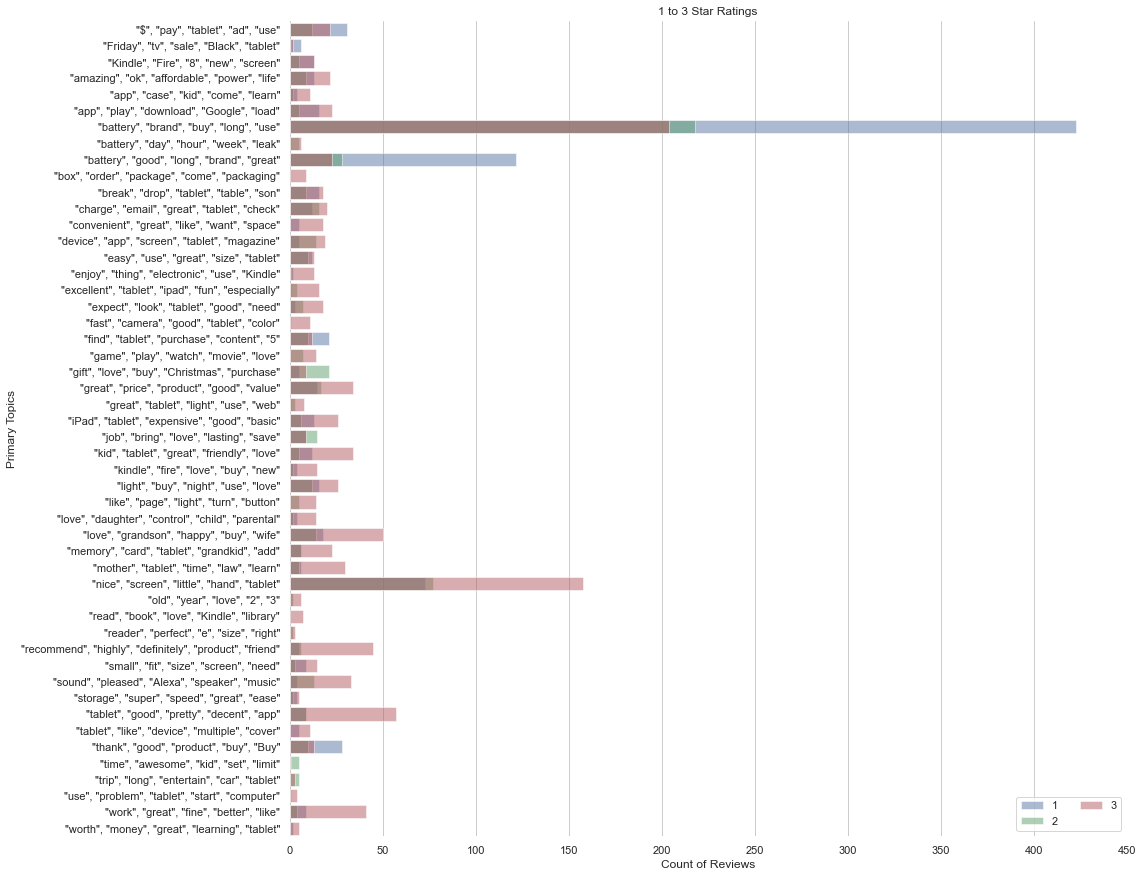

In [66]:
# 1 to 3 Star visualization
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Establish three bars with data
sns.barplot(x='1', y='primary_topic', data=agg, label="1", color="b", alpha=0.5)
sns.barplot(x='2', y='primary_topic', data=agg, label="2", color="g", alpha=0.5)
sns.barplot(x='3', y='primary_topic', data=agg, label="3", color="r", alpha=0.5)

# Legends, titles, and labels
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0,450), title='1 to 3 Star Ratings', ylabel="Primary Topics", xlabel="Count of Reviews")
sns.despine(left=True, bottom=True)

C:\Users\Tristan\anaconda3\envs\U4-S1-NLP\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


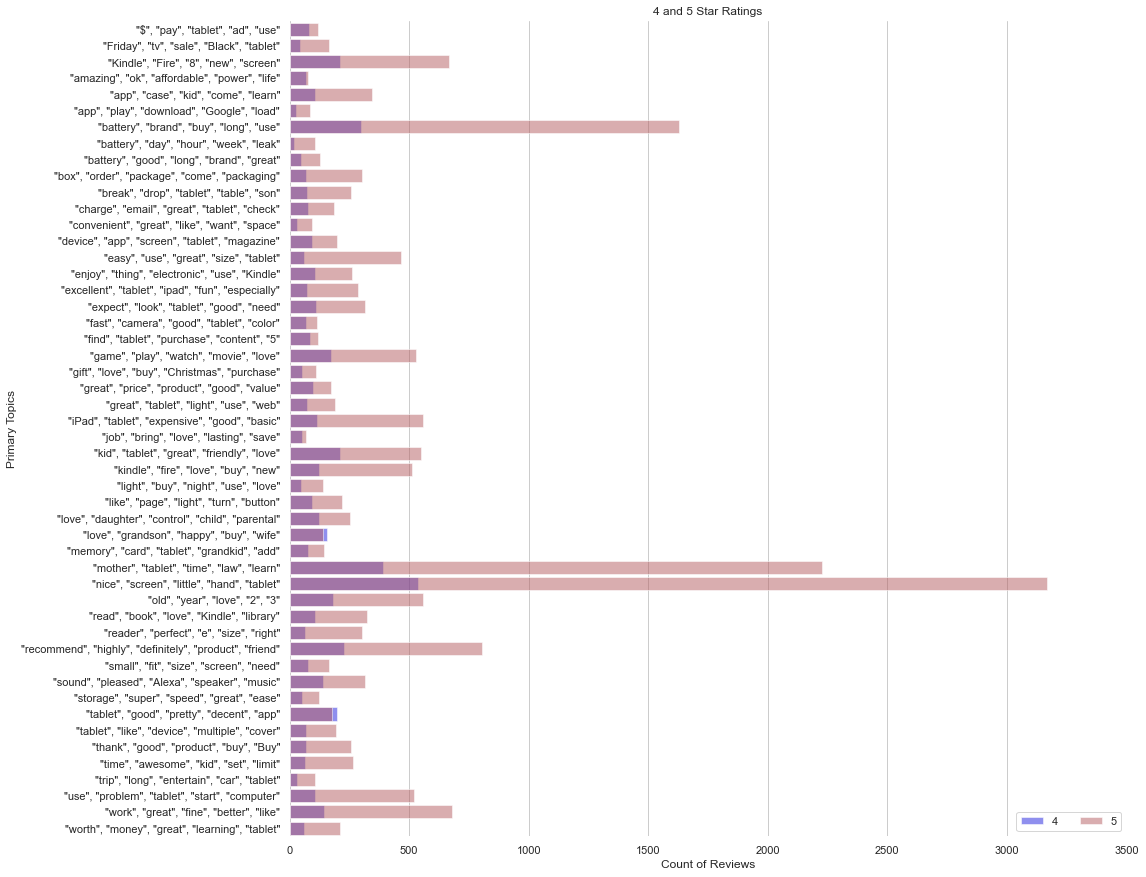

In [65]:
# 4 and 5 Star visualization
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Establish two bars with data
sns.barplot(x='4', y='primary_topic', data=agg, label="4", color="blue", alpha=0.5)
sns.barplot(x='5', y='primary_topic', data=agg, label="5", color="r", alpha=0.5)

# Legends, titles, and labels
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0,3500), title='4 and 5 Star Ratings', ylabel="Primary Topics", xlabel="Count of Reviews")
sns.despine(left=True, bottom=True)

# Observations and Findings

* Reviews tended toward being either rated as a 1 or a 5. It is my assumption that this is because people tend towards leaving reviews when either very satisfied or dissatisfied with a product.
* Primary Topic "battery""brand""buy""long""use" was the largest for 1 star topics, but the words alone I would have thought would have lead to better reviews.
* "tablet" appeared multiple times in 4/5 star primary topics, and was relatively non-existant for 1 to 3 star reviews.
* The scale of the two sets of visualizations was significantly different. (1-3 star at max were 450 counts, where 4-5 was almost 3500)

## Stretch Goals

* Incorporate Named Entity Recognition in your analysis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling